## Importing the libraries

In [15]:
import copy
from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from torch import nn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.utils.tensorboard import SummaryWriter
from ray import tune
from torchvision import datasets, transforms

# check to see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Getting the data

Training set has 60000 instances
Validation set has 10000 instances


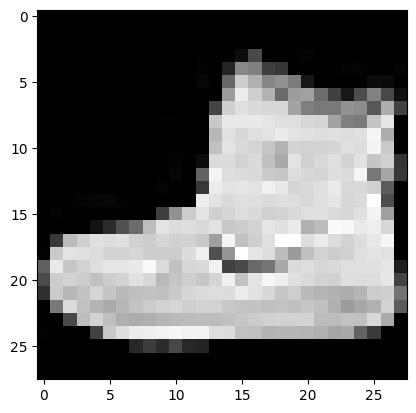

In [16]:
# Define a transform to normalize the data

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

def load_data(data_dir="./fmnist_data"):
    # Download the train and test data
    trainset = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    valset = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )

    return trainset, valset, 

trainset, valset = load_data()
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True)

# Labels in the data and their corresponding integer mapping
label_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Report split sizes
print("Training set has {} instances".format(len(trainset)))
print("Validation set has {} instances".format(len(valset)))

#Plotting the image
plt.imshow(trainset[0][0][0], cmap='gray')

## Building the Model

In [17]:
def LenetCNN():
    model = nn.Sequential(

        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(in_features=400, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=10),
    )
    return model

In [18]:
# validating the model
def validate(model, data):
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct * 100 / total

In [20]:
#training function
def train(epochs=3, learning_rate=1e-3, device='cpu'):

    accuracies = []

    cnn = LenetCNN().to(device)
    cel = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    max_accuracy = 0

    for epoch in range(epochs):
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cel(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy = float(validate(cnn, testloader))
        accuracies.append(accuracy)
        if accuracy>max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print('Saving the best model with accuracy', accuracy)

        print('Epoch :', epoch+1, 'Accuracy :', accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving the best model with accuracy 79.58999633789062
Epoch : 1 Accuracy : 79.58999633789062 %
Saving the best model with accuracy 85.11000061035156
Epoch : 2 Accuracy : 85.11000061035156 %
Saving the best model with accuracy 86.6500015258789
Epoch : 3 Accuracy : 86.6500015258789 %
Saving the best model with accuracy 87.70999908447266
Epoch : 4 Accuracy : 87.70999908447266 %
Saving the best model with accuracy 88.08000183105469
Epoch : 5 Accuracy : 88.08000183105469 %
Saving the best model with accuracy 88.61000061035156
Epoch : 6 Accuracy : 88.61000061035156 %
Saving the best model with accuracy 88.70999908447266
Epoch : 7 Accuracy : 88.70999908447266 %
Saving the best model with accuracy 89.33000183105469
Epoch : 8 Accuracy : 89.33000183105469 %
Saving the best model with accuracy 89.88999938964844
Epoch : 9 Accuracy : 89.88999938964844 %
Saving the best model with accuracy 89.9000015258789
Epoch : 10 Accuracy : 89.9000015258789 %
Saving the best model with accuracy 90.66999816894531

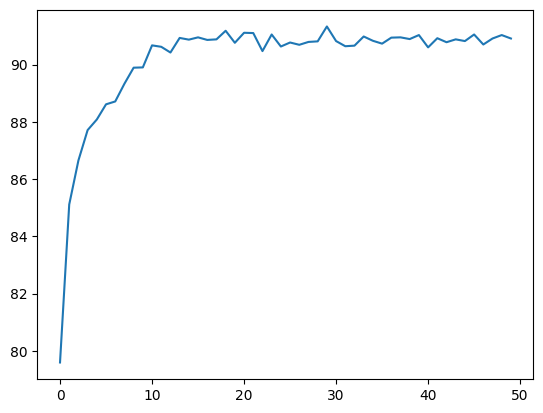

In [21]:
#training the model
lenet_model = train(epochs=50, learning_rate=0.001)

Model Test Accuracy : 0.9133
     0    1    2    3    4    5    6    7    8    9
0  888    1   10   14    3    1   72    0   11    0
1    3  982    0   10    1    0    2    0    2    0
2   18    1  859   13   43    0   64    0    2    0
3   14    3    9  924   22    0   24    0    4    0
4    1    1   44   26  849    0   79    0    0    0
5    2    0    0    0    0  975    0   19    0    4
6  128    2   41   16   65    0  736    0   12    0
7    1    0    0    0    0    5    0  969    0   25
8    6    1    2    3    2    1    3    2  979    1
9    0    0    0    0    0    7    0   20    1  972


<Axes: >

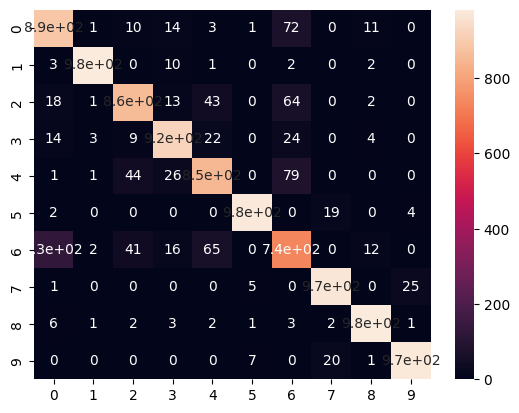

In [22]:
def predict_dataloader(model, data):
    y_pred = []
    y_true = []
    for i , (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch. max(x, 1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)


y_pred, y_true = predict_dataloader(lenet_model, testloader)
print('Model Test Accuracy :', accuracy_score(y_true=y_true, y_pred=y_pred))
conf_matrix = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred, labels=np.arange(0, 10)))
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True)

Predicted: T-shirt/Top, Probabiity: 99.20811653137207%


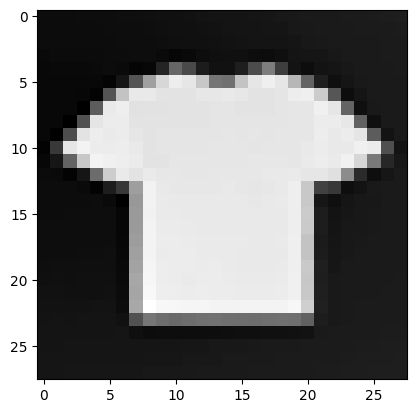

In [23]:
# Testing on out of sample dataset
# take images from the internet and pass through our model to see how well it is performing on unseen out of sample distribution  #TODO
def out_of_sample_validation(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        image = Image.open(f).convert(mode="L")
        image = image.resize((28, 28))
        x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
    with torch.no_grad():
        pred = model(torch.unsqueeze(transform(x), axis=1).float().to(device))
        return F.softmax(pred, dim=1).cpu().numpy()


# Displaying the image
path = "https://www.mrporter.com/variants/images/3633577411310824/in/w2000_q60.jpg"  # We can use any other image link here
r = requests.get(path)
with BytesIO(r.content) as f:
    image = Image.open(f).convert(mode="L")
    image = image.resize((28, 28))
    x = (255 - np.expand_dims(np.array(image), -1)) / 255.0
plt.imshow(x.squeeze(-1), cmap="gray")

# Predicting the out-of-sample image
out_of_sample_pred = out_of_sample_validation(path, lenet_model, device)
pred_id = np.argmax(out_of_sample_pred)
print(
    f"Predicted: {label_mapping[pred_id]}, Probabiity: {out_of_sample_pred[0][pred_id]*100}%"
)

In [ ]:
#Hyperparameter tuning


# Other

In [22]:
# cnn define cnn model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )

        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        # )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        # first hidden layer
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size=2, stride=2)

        # second hidden layer
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size=2)

        # third hidden layer
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)

        # fourth hidden layer
        out = self.fc2(out)

        # output layer
        out = self.fc3(out)

        return out


model = CNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [17]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = error(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(trainloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    print(last_loss)
    return last_loss


In [18]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(testloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = error(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/Users/parimi/anaconda3/envs/mathenv/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [79]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in trainloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1

        if not (count % 50):    # It's same as "if count % 50 == 0"
                total = 0
                correct = 0
            
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                
                    test = Variable(images.view(100, 1, 28, 28))
                
                    outputs = model(test)
                
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()
                
                    total += len(labels)
                
                accuracy = correct * 100 / total
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/Users/parimi/anaconda3/envs/mathenv/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.2793242037296295, Accuracy: 85.19000244140625%
Iteration: 1000, Loss: 0.16749633848667145, Accuracy: 89.54000091552734%
Iteration: 1500, Loss: 0.23099634051322937, Accuracy: 89.51000213623047%
Iteration: 2000, Loss: 0.298138290643692, Accuracy: 89.88999938964844%
Iteration: 2500, Loss: 0.1637721061706543, Accuracy: 90.0199966430664%
Iteration: 3000, Loss: 0.20130901038646698, Accuracy: 89.83999633789062%


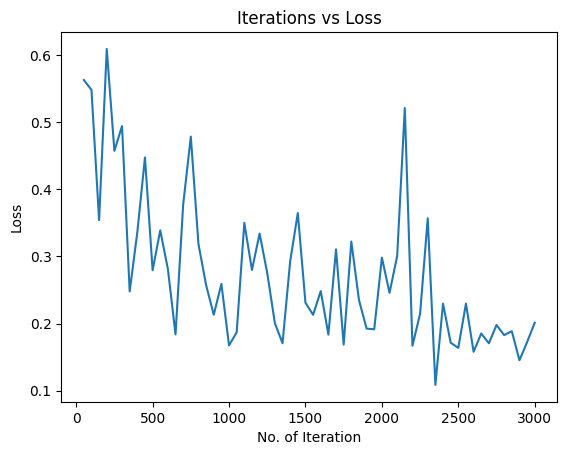

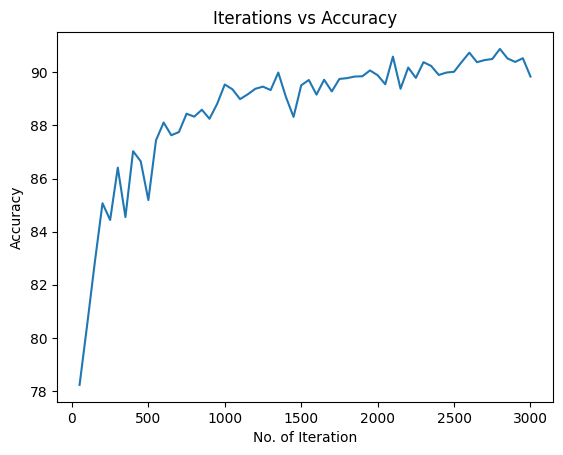

In [81]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [82]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(label_mapping[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 90.80%
Accuracy of Trouser: 96.90%
Accuracy of Pullover: 86.70%
Accuracy of Dress: 89.90%
Accuracy of Coat: 93.80%
Accuracy of Sandal: 97.80%
Accuracy of Shirt: 55.60%
Accuracy of Sneaker: 98.50%
Accuracy of Bag: 98.10%
Accuracy of Ankle Boot: 92.90%
